In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

# STEP 1: Prepare data generators
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    'train',                           # Your 'train' directory
    target_size=(256, 256),            # 256x256 mel spectrograms
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_data = val_gen.flow_from_directory(
    'validation',                      # Your 'validation' directory
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# STEP 2: Load base MobileNetV2 with 256x256 input
base_model = MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    alpha=1.0  # Optional (1.0 is default); you can change this to 0.75 or 1.4 for smaller/larger models
)
base_model.trainable = False  # Freeze base model layers

# STEP 3: Build the classification model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_data.num_classes, activation='softmax')  # Auto-matches number of output classes
])

# STEP 4: Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# STEP 5: Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('mobilenetv2_best_model_256x256.h5', save_best_only=True)

# STEP 6: Train the model
start_time = time.time()

model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

end_time = time.time()
print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes.")

# STEP 7: Save final model
model.save('mobilenetv2_final_model_256x256.h5')
print("\nModel saved as 'mobilenetv2_final_model_256x256.h5'")


Found 720 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Epoch 1/20
23/23 [==============================] - 9s 226ms/step - loss: 1.1154 - accuracy: 0.4611 - val_loss: 0.9943 - val_accuracy: 0.5000
Epoch 2/20
23/23 [==============================] - 2s 68ms/step - loss: 0.9191 - accuracy: 0.5458 - val_loss: 0.8026 - val_accuracy: 0.6000
Epoch 3/20
23/23 [==============================] - 2s 67ms/step - loss: 0.8283 - accuracy: 0.5861 - val_loss: 0.8003 - val_accuracy: 0.5667
Epoch 4/20
23/23 [==============================] - 2s 68ms/step - loss: 0.7500 - accuracy: 0.6500 - val_loss: 0.6964 - val_accuracy: 0.6556
Epoch 5/20
23/23 [==============================] - 2s 68ms/step - loss: 0.7127 - accuracy: 0.6819 - val_loss: 0.6826 - val_accuracy: 0.6556
Epoch 6/20
23/23 [==============================] - 2s 68ms/step - loss: 0.6728 - accuracy: 0.6958 - val_loss: 0.6036 - val_accuracy: 0.7333
Epoch 7/20
23/23 [==============================] - 1s 63ms/step - loss:

Found 90 images belonging to 3 classes.
3/3 [==============================] - 1s 87ms/step - loss: 0.4283 - accuracy: 0.8111

Final Test Accuracy: 81.11%
3/3 [==============================] - 0s 50ms/step

Classification Report:
              precision    recall  f1-score   support

        high       0.90      0.87      0.88        30
         low       0.70      0.93      0.80        30
    moderate       0.90      0.63      0.75        30

    accuracy                           0.81        90
   macro avg       0.83      0.81      0.81        90
weighted avg       0.83      0.81      0.81        90



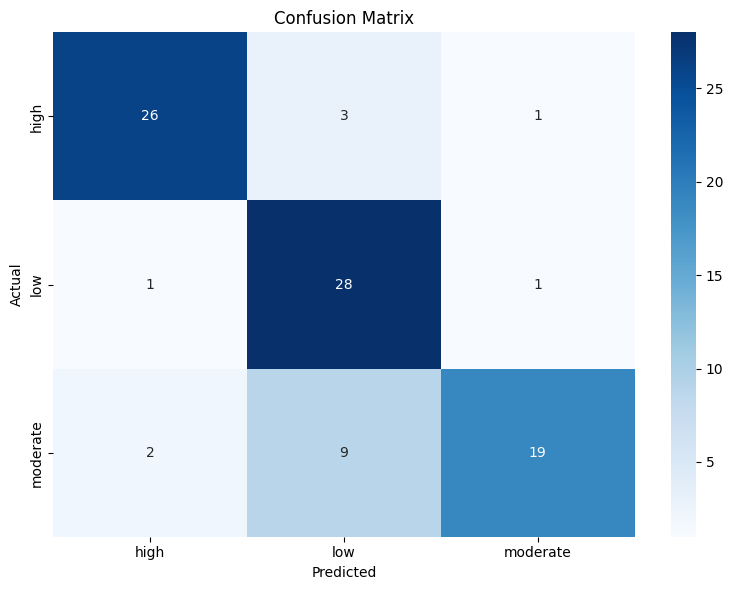


F1 Score (weighted): 0.8088
Sensitivity (Recall, weighted): 0.8111
Precision (weighted): 0.8338
Specificity (mean): 0.9056


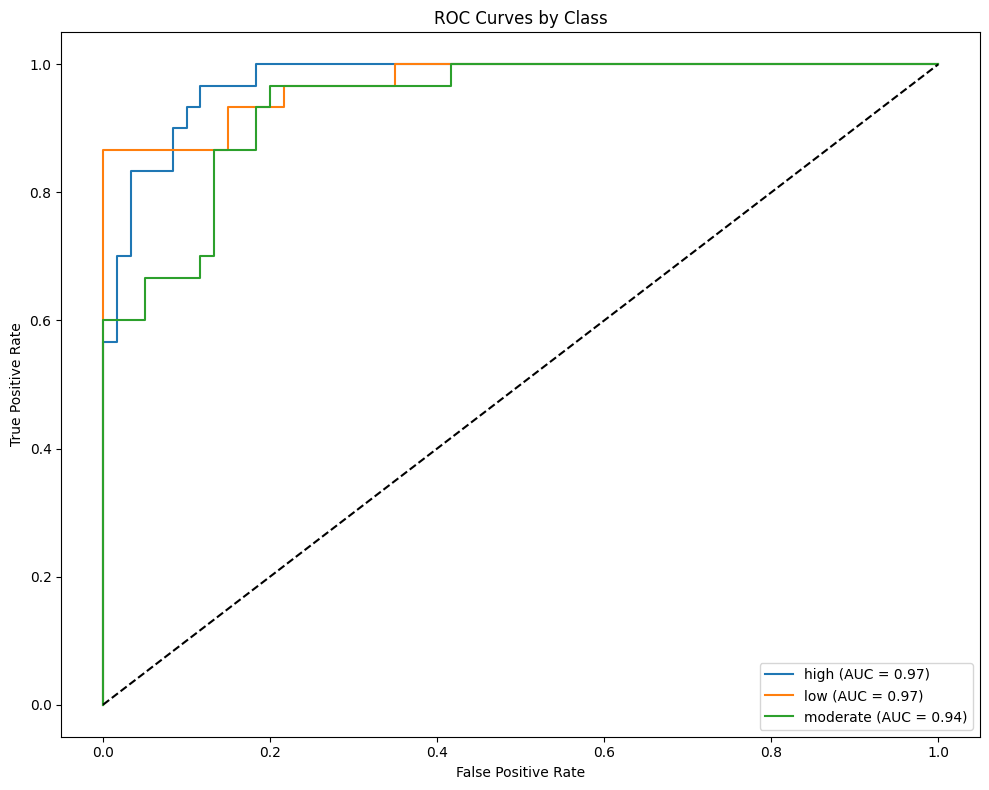

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, f1_score, recall_score, precision_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Load the trained model
model = load_model('mobilenetv2_final_model_256x256.h5')

# Prepare the test data generator
test_gen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_data = test_gen.flow_from_directory(
    'test',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model
loss, accuracy = model.evaluate(test_data, verbose=1)
print(f"\nFinal Test Accuracy: {accuracy * 100:.2f}%")

# Get true and predicted labels
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class names
class_names = list(test_data.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Compute and print additional metrics
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')  # Sensitivity
precision = precision_score(y_true, y_pred, average='weighted')

# Specificity (per class, average manually)
specificity = []
for i in range(len(class_names)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp + 1e-10))  # Avoid division by zero

mean_specificity = np.mean(specificity)

print(f"\nF1 Score (weighted): {f1:.4f}")
print(f"Sensitivity (Recall, weighted): {recall:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Specificity (mean): {mean_specificity:.4f}")

# ROC Curve and AUC (only for multi-class)
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

# Compute ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

# STEP 1: Prepare data generators
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    'train',                           # Your 'train' directory
    target_size=(256, 256),            # 256x256 mel spectrograms
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_data = val_gen.flow_from_directory(
    'validation',                      # Your 'validation' directory
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# STEP 2: Load base MobileNetV2 with 256x256 input
base_model = MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    alpha=1.0  # Optional (1.0 is default); you can change this to 0.75 or 1.4 for smaller/larger models
)
base_model.trainable = False  # Freeze base model layers

# STEP 3: Build the classification model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_data.num_classes, activation='softmax')  # Auto-matches number of output classes
])

from tensorflow.keras.optimizers import SGD

# STEP 4: Compile the model with SGD optimizer
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),  # You can adjust learning rate and momentum as needed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# STEP 5: Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('mobilenetv2_best_model_256x256.h5', save_best_only=True)

# STEP 6: Train the model
start_time = time.time()

model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

end_time = time.time()
print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes.")

# STEP 7: Save final model
model.save('mobilenetv2_final_model_256x256.h5')
print("\nModel saved as 'mobilenetv2_final_model_256x256.h5'")

Found 720 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Epoch 1/20
23/23 [==============================] - 3s 88ms/step - loss: 1.2773 - accuracy: 0.3972 - val_loss: 0.9852 - val_accuracy: 0.5000
Epoch 2/20
23/23 [==============================] - 2s 70ms/step - loss: 0.9621 - accuracy: 0.5264 - val_loss: 0.8829 - val_accuracy: 0.5222
Epoch 3/20
23/23 [==============================] - 1s 63ms/step - loss: 0.9813 - accuracy: 0.5153 - val_loss: 0.9291 - val_accuracy: 0.5333
Epoch 4/20
23/23 [==============================] - 1s 63ms/step - loss: 0.9252 - accuracy: 0.5625 - val_loss: 0.9115 - val_accuracy: 0.5667
Epoch 5/20
23/23 [==============================] - 1s 62ms/step - loss: 0.9151 - accuracy: 0.5569 - val_loss: 0.9015 - val_accuracy: 0.5667
Epoch 6/20
23/23 [==============================] - 2s 69ms/step - loss: 0.8924 - accuracy: 0.5361 - val_loss: 0.8249 - val_accuracy: 0.5444
Epoch 7/20
23/23 [==============================] - 2s 69ms/step - loss: 

Found 90 images belonging to 3 classes.
3/3 [==============================] - 1s 35ms/step - loss: 0.7066 - accuracy: 0.7111

Final Test Accuracy: 71.11%
3/3 [==============================] - 0s 52ms/step

Classification Report:
              precision    recall  f1-score   support

        high       0.75      0.90      0.82        30
         low       0.61      0.90      0.73        30
    moderate       1.00      0.33      0.50        30

    accuracy                           0.71        90
   macro avg       0.79      0.71      0.68        90
weighted avg       0.79      0.71      0.68        90



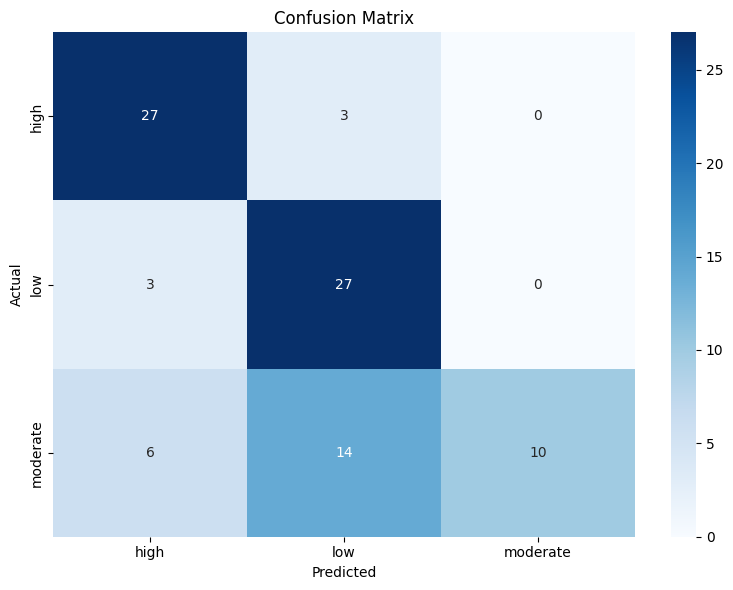


F1 Score (weighted): 0.6826
Sensitivity (Recall, weighted): 0.7111
Precision (weighted): 0.7879
Specificity (mean): 0.8556


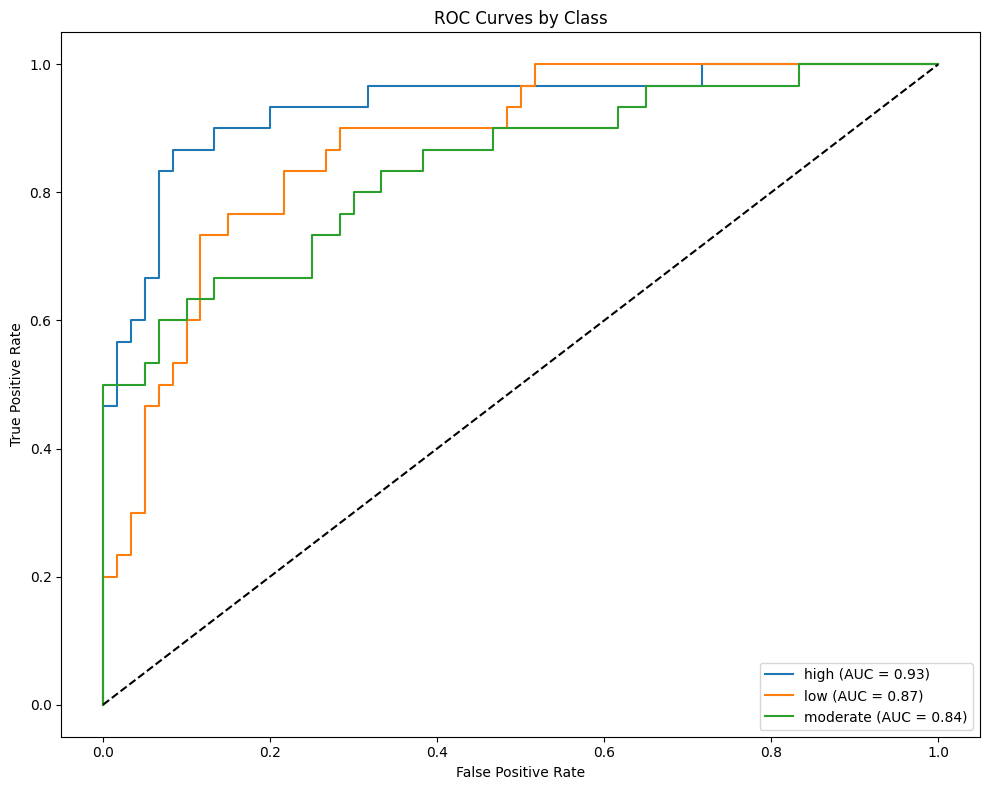

In [4]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, f1_score, recall_score, precision_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Load the trained model
model = load_model('mobilenetv2_final_model_256x256.h5')

# Prepare the test data generator
test_gen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_data = test_gen.flow_from_directory(
    'test',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model
loss, accuracy = model.evaluate(test_data, verbose=1)
print(f"\nFinal Test Accuracy: {accuracy * 100:.2f}%")

# Get true and predicted labels
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class names
class_names = list(test_data.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Compute and print additional metrics
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')  # Sensitivity
precision = precision_score(y_true, y_pred, average='weighted')

# Specificity (per class, average manually)
specificity = []
for i in range(len(class_names)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp + 1e-10))  # Avoid division by zero

mean_specificity = np.mean(specificity)

print(f"\nF1 Score (weighted): {f1:.4f}")
print(f"Sensitivity (Recall, weighted): {recall:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Specificity (mean): {mean_specificity:.4f}")

# ROC Curve and AUC (only for multi-class)
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

# Compute ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
# File: CNN/trainModel.py

import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

# -------------------------
# 0. Split dataset into train/val/test (80-10-10)
# -------------------------
def split_dataset(source_dir, target_base_dir, classes, split_ratio=(0.8, 0.1, 0.1)):
    for split in ['train', 'val', 'test']:
        for cls in classes:
            os.makedirs(os.path.join(target_base_dir, split, cls), exist_ok=True)

    for cls in classes:
        files = [f for f in os.listdir(os.path.join(source_dir, cls)) if f.endswith('.png')]
        random.shuffle(files)

        n_total = len(files)
        n_train = int(n_total * split_ratio[0])
        n_val = int(n_total * split_ratio[1])
        n_test = n_total - n_train - n_val

        train_files = files[:n_train]
        val_files = files[n_train:n_train + n_val]
        test_files = files[n_train + n_val:]

        splits = {
            'train': train_files,
            'val': val_files,
            'test': test_files
        }

        for split, file_list in splits.items():
            for file in file_list:
                src_path = os.path.join(source_dir, cls, file)
                dst_path = os.path.join(target_base_dir, split, cls, file)
                shutil.copy2(src_path, dst_path)

# -------------------------
# 1. Define your Stage 1 CNN model
# -------------------------
class Stage1CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(Stage1CNN, self).__init__()

        self.batch_norm = nn.BatchNorm2d(3)

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(5,7), padding=(2,3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2,3))

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,3))

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=(2,3))

        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.batch_norm(x)

        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool2(x)

        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool3(x)

        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# -------------------------
# 2. Define Dataloaders
# -------------------------
def create_dataloaders(base_path, batch_size=32):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    train_dataset = datasets.ImageFolder(os.path.join(base_path, 'train'), transform=transform)
    val_dataset = datasets.ImageFolder(os.path.join(base_path, 'val'), transform=transform)
    test_dataset = datasets.ImageFolder(os.path.join(base_path, 'test'), transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    print(f"Train set size: {len(train_dataset)} images")
    print(f"Validation set size: {len(val_dataset)} images")
    print(f"Test set size: {len(test_dataset)} images")
    print(f"Classes: {train_dataset.classes}")

    return train_loader, val_loader, test_loader

# -------------------------
# 3. Training Loop
# -------------------------
def train_model(model, train_loader, val_loader, num_epochs=15, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_accuracy = 0.0
    save_path = 'best_stage1_model.pth'

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved best model at epoch {epoch+1} with val acc {val_accuracy:.2f}%")

    print("\nTraining Completed.")
    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

# -------------------------
# 4. MAIN Execution
# -------------------------
if _name_ == '_main_':
    # Paths to already split folders
    train_path = r"C:\Users\pc_admin\Desktop\Kruthika\mini project 3rd year\train"
    val_path = r"C:\Users\pc_admin\Desktop\Kruthika\mini project 3rd year\validation"
    test_path = r"C:\Users\pc_admin\Desktop\Kruthika\mini project 3rd year\test"

    # Load Data
    train_loader, val_loader, test_loader = create_dataloaders_separate(train_path, val_path, test_path)

    # Train Model
    model = Stage1CNN(num_classes=3)
    train_model(model, train_loader, val_loader, num_epochs=15)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2969869046.py, line 198)